In [0]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
#print(os.listdir("../input/chest_xray/chest_xray/"))
from glob import glob
from PIL import Image
%matplotlib inline
import matplotlib.pyplot as plt
import cv2
import fnmatch
import keras
from time import sleep
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense,Conv2D,MaxPool2D,Dropout,Flatten,BatchNormalization,MaxPooling2D,Activation
from keras.optimizers import RMSprop,Adam
from tensorflow.keras.callbacks import EarlyStopping
from keras import backend as k

Using TensorFlow backend.


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
input_dir = '/content/drive/My Drive/chest_xray_4471/'
train_dir = input_dir +"train/"
test_dir = input_dir +"test/"
val_dir = input_dir +"val/"

In [0]:
# load each image three times
imagePatches = glob(input_dir + '*/**/*.jpeg', recursive=True)
print(len(imagePatches))

5856


In [0]:
# load images 3 times, in total 17568 images for training
pattern_normal = '*NORMAL*'
pattern_bacteria = '*_bacteria_*'
pattern_virus = '*_virus_*'

normal = fnmatch.filter(imagePatches, pattern_normal)
bacteria = fnmatch.filter(imagePatches, pattern_bacteria)
virus = fnmatch.filter(imagePatches, pattern_virus)
x = []
y = []
i = 0
for img in imagePatches:
    print(i)
    i = i+1
    full_size_image = cv2.imread(img)
    im = cv2.resize(full_size_image, (100, 100), interpolation=cv2.INTER_CUBIC)
    x.append(im)
    if img in normal:
        y.append(0)
    elif img in bacteria:
        y.append(1)
    elif img in virus:
        y.append(1)
    else:
        #break
        print('no class')
x = np.array(x)
y = np.array(y)

Streaming output truncated to the last 5000 lines.
856
857
858
859
860
861
862
863
864
865
866
867
868
869
870
871
872
873
874
875
876
877
878
879
880
881
882
883
884
885
886
887
888
889
890
891
892
893
894
895
896
897
898
899
900
901
902
903
904
905
906
907
908
909
910
911
912
913
914
915
916
917
918
919
920
921
922
923
924
925
926
927
928
929
930
931
932
933
934
935
936
937
938
939
940
941
942
943
944
945
946
947
948
949
950
951
952
953
954
955
956
957
958
959
960
961
962
963
964
965
966
967
968
969
970
971
972
973
974
975
976
977
978
979
980
981
982
983
984
985
986
987
988
989
990
991
992
993
994
995
996
997
998
999
1000
1001
1002
1003
1004
1005
1006
1007
1008
1009
1010
1011
1012
1013
1014
1015
1016
1017
1018
1019
1020
1021
1022
1023
1024
1025
1026
1027
1028
1029
1030
1031
1032
1033
1034
1035
1036
1037
1038
1039
1040
1041
1042
1043
1044
1045
1046
1047
1048
1049
1050
1051
1052
1053
1054
1055
1056
1057
1058
1059
1060
1061
1062
1063
1064
1065
1066
1067
1068
1069
1070
1071
1072
1073
107

In [0]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 101)
y_train = to_categorical(y_train, num_classes = 2)
y_test = to_categorical(y_test, num_classes = 2)
del x, y

In [0]:
import tensorflow as tf

In [0]:
from keras.applications import VGG16
def build_model(backbone, lr=1e-4):
    model = Sequential()
    model.add(backbone)
    model.add(Flatten())
    model.add(Dense(4096, activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(4096, activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(1000, activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(2,activation="softmax"))
    
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(lr=lr),
        metrics=['acc']
    )
    return model

vgg16 = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(100,100,3)
)

VGG16_100 = build_model(vgg16 ,lr = 1e-4)
VGG16_100.summary()

58892288/58889256 [==============================] - 2s 0us/step
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 3, 3, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 4608)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 4096)              18878464  
_________________________________________________________________
dropout_1 (Dropout)          (None, 4096)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 4096)              16781312  
_________________________________________________________________
dropout_2 (Dropout)          (None, 4096)              0         
_______________________________________________________

In [0]:
#es = EarlyStopping(patience=5)
#chkpt = ModelCheckpoint(filepath='/content/drive/My Drive/best_model_todate_vgg_redata_100', monitor = 'val_acc', save_best_only=True, save_weights_only=True)
hist = VGG16_100.fit(x_train,y_train,batch_size = 32, epochs = 1, verbose=1,  validation_split=0.2)

Train on 3747 samples, validate on 937 samples
Epoch 1/1
3747/3747 [==============================] - 17s 4ms/step - loss: 4.1506 - acc: 0.7286 - val_loss: 3.9939 - val_acc: 0.7396


In [0]:
from keras.applications.resnet50 import ResNet50
from keras.layers import Conv2D, MaxPooling2D, MaxPooling1D, GlobalAveragePooling2D, Dense, Dropout, Flatten, Input, LSTM, TimeDistributed
from keras.models import Sequential,Input,Model
input_tensor = Input(shape=(100,100,3))
base_model = ResNet50(input_tensor = input_tensor, include_top = False, pooling = 'average')
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1000, activation = 'relu')(x)
x = Dense(2, activation = 'softmax')(x)
Resnet_100 = Model(base_model.input,x)
Resnet_100.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics=['accuracy'])
Resnet_100.summary()

/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


94658560/94653016 [==============================] - 2s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 100, 100, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 106, 106, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 50, 50, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 50, 50, 64)   256         conv1[0][0]                      
___________________________

In [0]:
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
es = EarlyStopping(patience=10)
chkpt = ModelCheckpoint(filepath='/content/drive/My Drive/best_resnet_newdata', monitor = 'val_accuracy', save_best_only=True, save_weights_only=True)
hist = Resnet_100.fit(x_train,y_train,batch_size = 32, epochs = 40, verbose=1,  validation_split=0.2, callbacks=[chkpt, es])

Train on 3747 samples, validate on 937 samples
Epoch 1/40
3747/3747 [==============================] - 16s 4ms/step - loss: 0.0260 - accuracy: 0.9920 - val_loss: 5.4198 - val_accuracy: 0.8815
Epoch 2/40
3747/3747 [==============================] - 16s 4ms/step - loss: 0.0231 - accuracy: 0.9923 - val_loss: 0.4011 - val_accuracy: 0.9061
Epoch 3/40
3747/3747 [==============================] - 16s 4ms/step - loss: 0.0221 - accuracy: 0.9931 - val_loss: 0.1806 - val_accuracy: 0.9605
Epoch 4/40
3747/3747 [==============================] - 16s 4ms/step - loss: 0.0326 - accuracy: 0.9888 - val_loss: 0.5612 - val_accuracy: 0.8975
Epoch 5/40
3747/3747 [==============================] - 16s 4ms/step - loss: 0.0299 - accuracy: 0.9915 - val_loss: 1.0303 - val_accuracy: 0.7673
Epoch 6/40
3747/3747 [==============================] - 16s 4ms/step - loss: 0.0764 - accuracy: 0.9760 - val_loss: 6.8576 - val_accuracy: 0.8719
Epoch 7/40
3747/3747 [==============================] - 16s 4ms/step - loss: 0.0295

In [0]:
from keras import layers
bnmomemtum=0.9
def fire(x, squeeze, expand):
  y  = layers.Conv2D(filters=squeeze, kernel_size=1, activation='relu', padding='same')(x)
  y = layers.BatchNormalization(momentum=bnmomemtum)(y)
  y1 = layers.Conv2D(filters=expand//2, kernel_size=1, activation='relu', padding='same')(y)
  y1 = layers.BatchNormalization(momentum=bnmomemtum)(y1)
  y3 = layers.Conv2D(filters=expand//2, kernel_size=3, activation='relu', padding='same')(y)
  y3 = layers.BatchNormalization(momentum=bnmomemtum)(y3)
  return layers.concatenate([y1, y3])

def fire_module(squeeze, expand):
  return lambda x: fire(x, squeeze, expand)

x = layers.Input(shape=[100, 100, 3]) # input is 192x192 pixels RGB

y = layers.Conv2D(kernel_size=3, filters=32, padding='same', use_bias=True, activation='relu')(x)
y = layers.BatchNormalization(momentum=bnmomemtum)(y)
y = fire_module(24, 48)(y)
y = layers.MaxPooling2D(pool_size=2)(y)
y = fire_module(48, 96)(y)
y = layers.MaxPooling2D(pool_size=2)(y)
y = fire_module(64, 128)(y)
y = layers.MaxPooling2D(pool_size=2)(y)
y = fire_module(48, 96)(y)
y = layers.MaxPooling2D(pool_size=2)(y)
y = fire_module(24, 48)(y)
y = layers.GlobalAveragePooling2D()(y)
y = layers.Dense(2, activation='softmax')(y)

Squeezenet_100 = Model(x, y)

Squeezenet_100.compile(
    optimizer='adam',
    loss= 'categorical_crossentropy',
    metrics=['accuracy'])

Squeezenet_100.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 100, 100, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 100, 100, 32) 896         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 100, 100, 32) 128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 100, 100, 24) 792         batch_normalization_1[0][0]      
____________________________________________________________________________________________

In [0]:
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
es = EarlyStopping(patience=10)
chkpt = ModelCheckpoint(filepath='/content/drive/My Drive/best_squeezenet_newdata', monitor = 'val_accuracy', save_best_only=True, save_weights_only=True)
hist = Squeezenet_100.fit(x_train,y_train,batch_size = 32, epochs = 40, verbose=1,  validation_split=0.2, callbacks=[chkpt, es])

Train on 3747 samples, validate on 937 samples
Epoch 1/40
3747/3747 [==============================] - 8s 2ms/step - loss: 0.0680 - accuracy: 0.9749 - val_loss: 0.1099 - val_accuracy: 0.9530
Epoch 2/40
3747/3747 [==============================] - 8s 2ms/step - loss: 0.0503 - accuracy: 0.9819 - val_loss: 0.0881 - val_accuracy: 0.9723
Epoch 3/40
3747/3747 [==============================] - 8s 2ms/step - loss: 0.0505 - accuracy: 0.9829 - val_loss: 0.0897 - val_accuracy: 0.9616
Epoch 4/40
3747/3747 [==============================] - 8s 2ms/step - loss: 0.0288 - accuracy: 0.9923 - val_loss: 1.4860 - val_accuracy: 0.6158
Epoch 5/40
3747/3747 [==============================] - 8s 2ms/step - loss: 0.1094 - accuracy: 0.9586 - val_loss: 0.0839 - val_accuracy: 0.9669
Epoch 6/40
3747/3747 [==============================] - 8s 2ms/step - loss: 0.0529 - accuracy: 0.9808 - val_loss: 0.0996 - val_accuracy: 0.9691
Epoch 7/40
3747/3747 [==============================] - 8s 2ms/step - loss: 0.0414 - accu

In [0]:
Squeezenet_100.load_weights('/content/drive/My Drive/best_squeezenet_newdata') #es = 10

In [0]:
from sklearn.metrics import classification_report
pred = Squeezenet_100.predict(x_test)
print(classification_report(np.argmax(y_test, axis = 1),np.argmax(pred, axis = 1)))

              precision    recall  f1-score   support

           0       0.96      0.92      0.94       327
           1       0.97      0.98      0.98       845

    accuracy                           0.97      1172
   macro avg       0.96      0.95      0.96      1172
weighted avg       0.97      0.97      0.97      1172



In [0]:
%cd /content/drive/My Drive
from keras.models import load_model
models=[]
'''
for i in range(numOfModels):

    modelTemp=load_model(path2modelx) # load model
    modelTemp.name="aUniqueModelName" # change name to be unique
    models.append(modelTemp)
'''
VGG16_100.load_weights('VGG_100_change_ds')
#modelTemp1.name="VGG16_!00" # change name to be unique
models.append(VGG16_100)

Resnet_100.load_weights('model_check_path_5856')
'''
#modelTemp2.name="Resnet_100" # change name to be unique
models.append(Resnet_100)
'''
Squeezenet_100.load_weights('best_squeezenet_newdata')
#modelTemp3.name="Squeezenet_100" # change name to be unique
models.append(Squeezenet_100)


/content/drive/My Drive


In [0]:
def ensembleModels(models, model_input):
    # collect outputs of models in a list
    yModels=[model(model_input) for model in models] 
    # averaging outputs
    yAvg=keras.layers.average(yModels) 
    # build model from same input and avg output
    modelEns = Model(inputs=model_input, outputs=yAvg, name='ensemble')  
   
    return modelEns

In [0]:
model_input = Input(shape=models[0].input_shape[1:]) # c*h*w
modelEns = ensembleModels(models, model_input)
modelEns.summary()

Model: "ensemble"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 100, 100, 3)  0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 2)            54473466    input_4[0][0]                    
__________________________________________________________________________________________________
model_2 (Model)                 (None, 2)            120466      input_4[0][0]                    
__________________________________________________________________________________________________
average_1 (Average)             (None, 2)            0           sequential_1[1][0]               
                                                                 model_2[1][0]             

In [0]:
from sklearn.metrics import classification_report
pred = modelEns.predict(x_test)
print(classification_report(np.argmax(y_test, axis = 1),np.argmax(pred, axis = 1), digits=4))

              precision    recall  f1-score   support

           0     0.9840    0.9388    0.9609       327
           1     0.9767    0.9941    0.9853       845

    accuracy                         0.9787      1172
   macro avg     0.9804    0.9665    0.9731      1172
weighted avg     0.9788    0.9787    0.9785      1172



<Figure size 432x288 with 0 Axes>

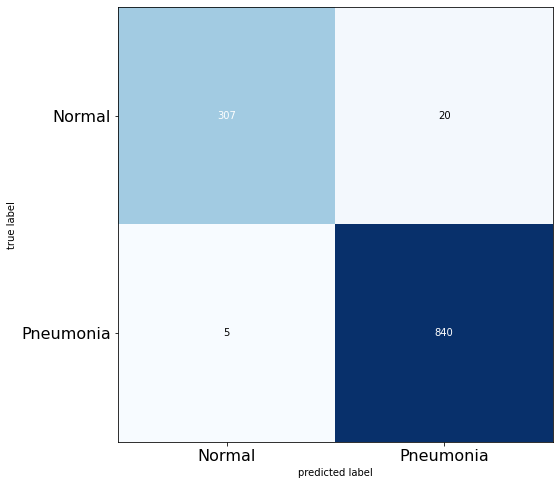

In [0]:
import numpy as np
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
labels = np.argmax(y_test, axis=-1)
pred_ensemble = np.argmax(pred, axis=-1)
cm  = confusion_matrix(labels, pred_ensemble)
plt.figure()
plot_confusion_matrix(cm,figsize=(12,8), hide_ticks=True, cmap=plt.cm.Blues)
plt.xticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.yticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.show()

In [0]:
pred = Squeezenet_100.predict(x_test)
print(classification_report(np.argmax(y_test, axis = 1),np.argmax(pred, axis = 1), digits=4))

              precision    recall  f1-score   support

           0     0.9557    0.9235    0.9393       327
           1     0.9708    0.9834    0.9771       845

    accuracy                         0.9667      1172
   macro avg     0.9632    0.9535    0.9582      1172
weighted avg     0.9666    0.9667    0.9665      1172



<Figure size 432x288 with 0 Axes>

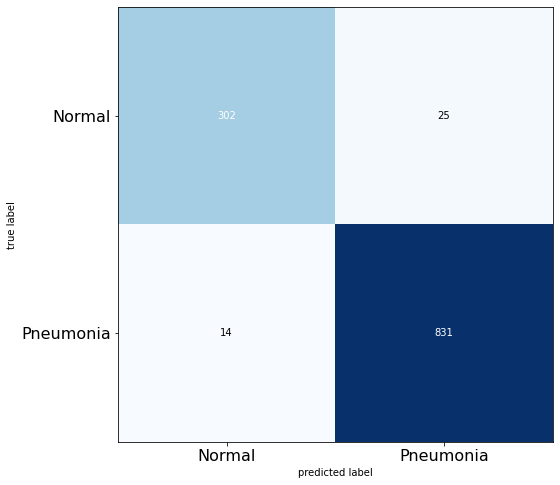

In [0]:
pred_sqz = np.argmax(pred, axis=-1)
cm  = confusion_matrix(labels, pred_sqz)
plt.figure()
plot_confusion_matrix(cm,figsize=(12,8), hide_ticks=True, cmap=plt.cm.Blues)
plt.xticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.yticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.show()

In [0]:
pred = VGG16_100.predict(x_test)
print(classification_report(np.argmax(y_test, axis = 1),np.argmax(pred, axis = 1), digits=4))

              precision    recall  f1-score   support

           0     0.9568    0.9480    0.9524       327
           1     0.9800    0.9834    0.9817       845

    accuracy                         0.9735      1172
   macro avg     0.9684    0.9657    0.9670      1172
weighted avg     0.9735    0.9735    0.9735      1172



<Figure size 432x288 with 0 Axes>

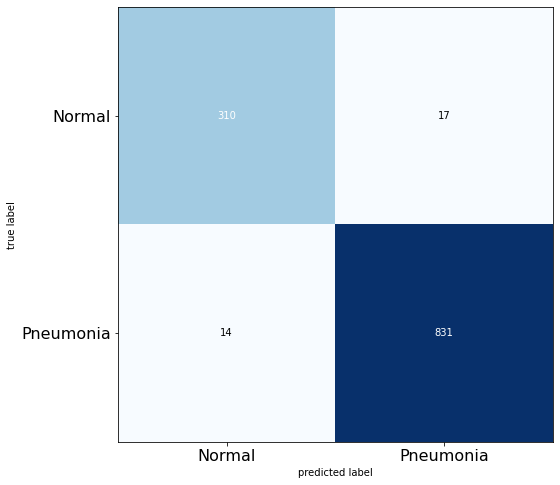

In [0]:
pred_vgg = np.argmax(pred, axis=-1)
cm  = confusion_matrix(labels, pred_vgg)
plt.figure()
plot_confusion_matrix(cm,figsize=(12,8), hide_ticks=True, cmap=plt.cm.Blues)
plt.xticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.yticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.show()

In [0]:
pred = Resnet_100.predict(x_test)
print(classification_report(np.argmax(y_test, axis = 1),np.argmax(pred, axis = 1), digits=4))

              precision    recall  f1-score   support

           0     0.9551    0.9113    0.9327       327
           1     0.9663    0.9834    0.9748       845

    accuracy                         0.9633      1172
   macro avg     0.9607    0.9474    0.9537      1172
weighted avg     0.9632    0.9633    0.9630      1172



<Figure size 432x288 with 0 Axes>

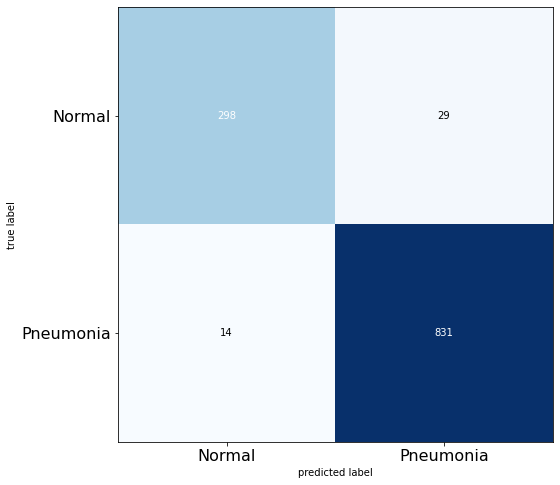

In [0]:
pred_res = np.argmax(pred, axis=-1)
cm  = confusion_matrix(labels, pred_res)
plt.figure()
plot_confusion_matrix(cm,figsize=(12,8), hide_ticks=True, cmap=plt.cm.Blues)
plt.xticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.yticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.show()